## 2D SSN simulation ~  JAX IMPLEMENTATION

Changes required by JAX:
- jax.random vs numpy.random
- introduction of key variables to operate in random **
- np.chararray substituted -> created separate boolean array after locating indices in a list because jax doesnt support character arrays

In [ ]:
#import numpy as np
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
from jax import random

from SSN_classes_jax import SSN2DTopoV1_AMPAGABA
from util import GaborFilter, BW_Grating, find_A

## Parameters for network initialisation

Resolution of SSN grid: 2.8125 pixels / degree

In [2]:
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi


# with mm_scale=1, The following match "fixed_params" of  'Fig4_data-retinoHists-samples1000_TauCorr5_2020-04-11.json'
class grid_pars():
    gridsize_Nx = 8 + 1 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141
sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
conn_pars = dict(
    PERIODIC = False,
    J_2x2 = ssn_pars.make_J2x2(*Js0),
    s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]]), # in mm
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris

conn_pars['J_2x2'] = ssn_pars.make_J2x2(*Js0)

#calculate SSN resolution
SSN_reso = grid_pars.gridsize_Nx/grid_pars.gridsize_deg #pixels per degree

## Initialise network

In [6]:
#Create network

## SPECIFY 'on_off' PARAMETER TO DOUBLE NUMBER OF NEURONS AT PI PHASE
ssn = SSN2DTopoV1_AMPAGABA(ssn_pars.n, ssn_pars.k, ssn_pars.tauE,
              ssn_pars.tauI, grid_pars, on_off=True, conn_pars=conn_pars,  tau_s=ssn_pars.tau_s)

In [7]:
ssn.W.shape

(324, 324)

## Gabor function implementation

Parameters for Gabor filters

In [10]:
#Parameters for Gabor filters
edge_length=3.2  #image edge length in degrees
dx_i =1/2.8125 #image pixel resolution in degrees (degrees/pixel)
N_pixels=int(edge_length*2/dx_i) +1  # can also specify these directly

#Reproduce image axis in degrees
x_axis=np.linspace(-edge_length,edge_length, N_pixels, endpoint=True)  
y_axis=np.linspace(-edge_length,edge_length, N_pixels, endpoint=True)

#Sigma_g= edge_length/8 #degree #0.5 - 1degree
sigma_g= 0.5
k= np.pi/(6*sigma_g) #cycles per degree

Iterate over neurons in SSN map

In [11]:
#Create empty arrays
all_gabors=[] #array of Gabor classes
e_filters=[] #array of filters

#Iterate over SSN map
for i in range(ssn.ori_map.shape[0]):
    for j in range(ssn.ori_map.shape[1]):
        gabor=GaborFilter(x_i=ssn.x_map[i,j], y_i=ssn.y_map[i,j], k=k, sigma_g=sigma_g, theta=ssn.ori_map[i,j], conv_factor=grid_pars.magnif_factor, x_axis=x_axis, y_axis=y_axis, dx=dx_i, dy=dx_i)
        
        e_filters.append(gabor.filter.ravel())
e_filters=np.array(e_filters)

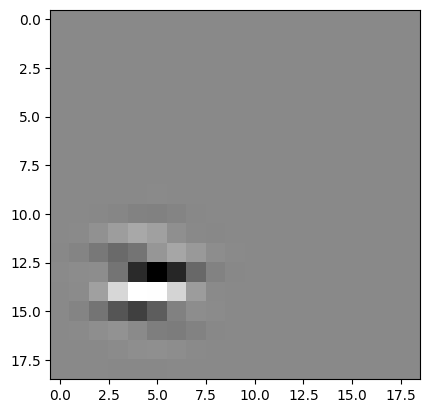

In [12]:
#Plot example filter
plt.imshow(e_filters[0].reshape(N_pixels, N_pixels), cmap='Greys')

Create inhibitory Gabor filters

In [13]:
i_constant= 1
i_filters=np.multiply(i_constant, e_filters)
all_filters=np.vstack([e_filters, i_filters]) #shape - (n_neurons, n_pixels in image(n_pixels_x_axis*n_pixels_y_axis))

## Jia stimuli

Import stimuli. Parameters to specify:
- orientation -  in degrees from vertical (anti clockwise) - HAD TO ROTATE CREATION OF GABOR FILTERS!
- size - in pixels 227*227
- outer radius + inner radius
- pixels per degree
- grating contrast - up to 1 (*100 in SSN code)
- snr - 0<= snr <= 1
- phase - in degrees
- spatial frequency - in 1/pixels (need to multiply k* dx_i - dx_i in degrees/pixel)

In [14]:
#Stimulus parameters
ori_deg=90
edge_deg=3.2
phase = 0 #uses random
outer_radius = 3
inner_radius = 2.5
pixel_per_degree=2.8125 #19.19
grating_contrast = 0.99

size=int(edge_deg*2 *pixel_per_degree) + 1
size

19

In [15]:
test_grating=BW_Grating(ori_deg=ori_deg, size=size, outer_radius=outer_radius, inner_radius=inner_radius, pixel_per_degree=pixel_per_degree, grating_contrast=grating_contrast, snr=1, phase=phase, spatial_frequency=k*dx_i)
test_stimuli=test_grating.BW_image()#shape - (n_pixels in image(n_pixels_x_axis*n_pixels_y_axis, 1)

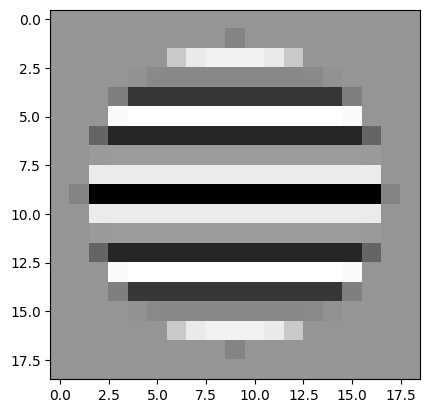

In [16]:
plt.imshow(test_stimuli, cmap='Greys')

### Apply filters to stimulus

Multiply flattened filters by flattened image

In [ ]:
#multiply filters my image
output_gabor=np.matmul(all_filters, test_stimuli.ravel())*A 

#check maximum response is obtained at orientation of stimulus
ssn.ori_map.ravel()[np.argmax(output_gabor)]

### --->Finding average value of constant A over different Gabor filters

1. Select list of indices 

In [17]:
#OPTION 1 - choose random values for the orientation 
key = random.PRNGKey(90)
random_nums=random.choice(key, a=ssn.ori_map)
#indices=random_nums

#OPTION 2 - select angles in spread out range - selects every given number of angles
indices=np.sort(ssn.ori_map.ravel())

2. Run loop for different orientations - must centre Gabors at 0

In [18]:
#parameters for Gabor filters
gabor_pars = dict(k=k, sigma_g=sigma_g, conv_factor=grid_pars.magnif_factor, 
                  x_axis=x_axis, y_axis=y_axis, dx=dx_i, dy=dx_i )


#parameters for stimuli
stimuli_pars = dict(size=N_pixels, outer_radius=10, inner_radius=10,
                    pixel_per_degree=1/dx_i, grating_contrast=0.9, snr=1, phase=0, spatial_frequency=k*dx_i)



A, all_gabors, all_test_stimuli = find_A(gabor_pars, stimuli_pars, indices, return_all=True)

Average A is 0.04553933353469378


In [ ]:
#check average value 
output_test=0
for i in range (len(all_gabors)):
    output_test+=np.matmul(all_gabors[i].ravel(), all_test_stimuli[i].ravel())*A
print(output_test/len(all_gabors))

## Extend filters to pi phase

In [19]:
#create filters with phase equal to pi
off_all_filters=all_filters*(-1)
SSN_filters=np.vstack([all_filters, off_all_filters])

#find response to the stimulus of filters with phase pi
output_gabor_off=np.matmul(SSN_filters, test_stimuli.ravel())*A

#Rectigy input
SSN_input=np.maximum(0, output_gabor_off)

## Input to network

In [23]:
#Convergence parameters
dt = 1
xtol = 1e-5
Tmax = 200

#Find fixed point using input
r_init = np.zeros(SSN_input.shape[0])
r_fps, CONVG = ssn.fixed_point_r(SSN_input, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)


 Warning 1: reached Tmax=200, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = 0.0009526073699817061,   xtol=1e-05.

Did not reach fixed point.
